In [1]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Data visualization

In [2]:
file_name = 'CESM_EA_SPI.nc'
ds = xr.open_dataset(file_name)
spi = ds['spi']
spi

<xarray.DataArray 'spi' (time: 21612, lat: 13, lon: 20)>
[5619120 values with dtype=float64]
Coordinates:
  * time     (time) object '0400-01-16T12:00:00' ... '2200-12-16T12:00:00'
  * lat      (lat) float64 3.298 4.241 5.183 6.126 ... 11.78 12.72 13.66 14.61
  * lon      (lon) float64 23.75 25.0 26.25 27.5 28.75 ... 43.75 45.0 46.25 47.5
Attributes:
    title:          Standardized Precipitation Index
    standard_name:  atmosphere_water__standardized_precipitation_wetness_index
    long_name:      Standardized Precipitation Index
    units:          unitless
    valid_min:      -3.09
    valid_max:      3.09
    valid_range:    [-3.09  3.09]

1954


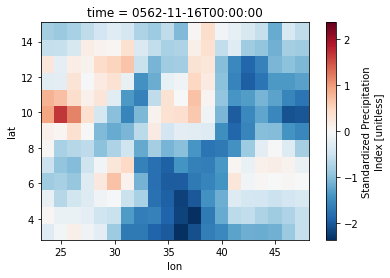

In [19]:
#plot spatial spi distribution for random time
time = np.random.randint(spi.shape[0])
print(time)
spi2d = spi.isel(time=time)
spi2d.plot()

5 0 9745


Text(0, 0.5, 'SPI')

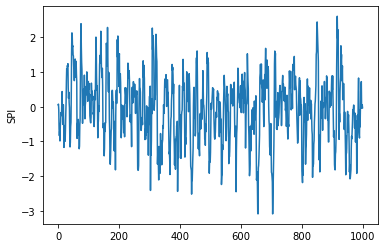

In [20]:
#plot spi time series at random location
lat = np.random.randint(spi.shape[1])
lon = np.random.randint(spi.shape[2])
k = np.random.randint(spi.shape[0]-1000)
print(lat,lon,k)
plt.plot(spi[k:k+1000,lat,lon])
plt.ylabel('SPI')

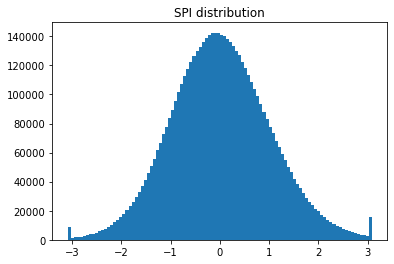

(5619120,)


In [21]:
#plot overall spi distribution
plt.hist(np.array(spi).flatten(), bins=100)
plt.title('SPI distribution')
plt.show()
print(np.shape(np.array(spi).flatten()))

# Prepare data

In [3]:
def assemble_predictors_predictands(start_date, end_date, lead_time, dataset, num_input_time_steps):
    '''
    Args
    ----
    start_date (str): The start date for extraction. Important, put the trailing 0 at the beginning of year for dates before 1000 (e.g., '0400')
    end_date (str): The end date for extraction
    lead_time (int): The number of months between the predictor/predictand
    dataset (str): Either 'CESM' or 'ECMWF'
    num_input_time_steps (int): The number of time steps to use for each predictor samples
    '''    
    file_name = {'CESM': 'CESM_EA_SPI.nc', 'ECMWF': 'ECMWF_EA_SPI.nc'}[dataset]
    ds = xr.open_dataset(file_name)
    spi = ds['spi'].sel(time=slice(start_date,end_date))   # 3D (time,lat,lon)
    num_samples=spi.shape[0]
    #Stack and remove nans
    spi = np.stack([spi.values[n-num_input_time_steps:n] for n in range(num_input_time_steps, num_samples+1)])
    num_samples = spi.shape[0]
    spi[np.isnan(spi)] = 0   # 4D (time,timestep,lat,lon)
    #make sure we have floats in there
    X = spi.astype(np.float32)
    # select Y
    if dataset == 'ECMWF':
        start_date_plus_lead = pd.to_datetime(start_date) + pd.DateOffset(months=lead_time+num_input_time_steps-1)
        end_date_plus_lead = pd.to_datetime(end_date) + pd.DateOffset(months=lead_time)
    elif dataset == 'CESM':
        t_start=datetime.datetime(int(start_date.split('-')[0]),int(start_date.split('-')[1]),int(start_date.split('-')[2]))
        t_end=datetime.datetime(int(end_date.split('-')[0]),int(end_date.split('-')[1]),int(end_date.split('-')[2]))
        start_date_plus_lead = t_start + relativedelta(months=lead_time+num_input_time_steps-1)
        end_date_plus_lead = t_end + relativedelta(months=lead_time)
        if len(str(start_date_plus_lead.year))<4:
            start_date_plus_lead = '0'+start_date_plus_lead.strftime('%Y-%m-%d')
        elif len(str(start_date_plus_lead.year))==4:
            start_date_plus_lead = start_date_plus_lead.strftime('%Y-%m-%d')
        if len(str(end_date_plus_lead.year))<4:
            end_date_plus_lead = '0'+end_date_plus_lead.strftime('%Y-%m-%d')
        elif len(str(end_date_plus_lead.year))==4:
            end_date_plus_lead = end_date_plus_lead.strftime('%Y-%m-%d')
    subsetted_ds = ds['spi'].sel(time=slice(start_date_plus_lead, end_date_plus_lead))
    y = subsetted_ds.values.astype(np.float32) # 3D (time,lat,lon)
    y[np.isnan(y)] = 0
    ds.close()
    X = np.moveaxis(X, 1,3) # 4D(time,lat,lon,timestep)
    orig_shape_X = X.shape
    orig_shape_y = y.shape
    y = y.reshape(np.shape(y)[0]*np.shape(y)[1]*np.shape(y)[2])
    
    X = X.reshape(np.shape(X)[0]*np.shape(X)[1]*np.shape(X)[2], np.shape(X)[3])
    return X,y, orig_shape_X, orig_shape_y

In [4]:
##Parameters
num_input_time_steps = 3 
lead_time = 3

num_epochs = 100

climate_model = 'CESM'
train_start_date = '0400-01-01'
train_end_date = '1950-12-31'

valid_start_date = '1951-01-01'
valid_end_date = '2000-12-31'

test_start_date = '2001-01-01'
test_end_date = '2100-12-31'

In [5]:
train_predictors, train_predictands, orig_shape_Xtrain, orig_shape_ytrain = assemble_predictors_predictands(train_start_date, train_end_date, lead_time, climate_model, num_input_time_steps)
valid_predictors, valid_predictands, orig_shape_Xvalid, orig_shape_yvalid = assemble_predictors_predictands(valid_start_date, valid_end_date, lead_time, climate_model,num_input_time_steps)
test_predictors, test_predictands, orig_shape_Xtest, orig_shape_ytest = assemble_predictors_predictands(test_start_date, test_end_date, lead_time, climate_model,num_input_time_steps)

In [6]:
print(np.shape(train_predictors),np.shape(train_predictands))
print(np.shape(valid_predictors),np.shape(valid_predictands))
print(np.shape(test_predictors),np.shape(test_predictands))
lat = ds['lat']
lon = ds['lon']
lat = np.array(lat)
lon = np.array(lon)
nlat = len(lat)
nlon = len(lon)
print(nlat,nlon)

(4838600, 3) (4838600,)
(155480, 3) (155480,)
(311480, 3) (311480,)
13 20


# multiple linear regression baseline

In [27]:
regr = LinearRegression()
regr.fit(train_predictors, train_predictands)

LinearRegression()

In [28]:
pred = regr.predict(test_predictors)
print(np.shape(test_predictands),np.shape(pred))

(311480,) (311480,)


In [29]:
mse = mean_squared_error(pred, test_predictands)
print('MSE:', mse)

MSE: 0.6779862


In [7]:
train_xt = train_predictors.reshape(orig_shape_Xtrain)
train_yt = train_predictands.reshape(orig_shape_ytrain)
valid_xt = valid_predictors.reshape(orig_shape_Xvalid)
test_xt = test_predictors.reshape(orig_shape_Xtest)
print(train_xt.shape,valid_xt.shape,test_xt.shape,train_yt.shape)

(18610, 13, 20, 3) (598, 13, 20, 3) (1198, 13, 20, 3) (18610, 13, 20)


In [8]:
# prepare data for parallel training
train_x = np.ndarray((len(train_xt),nlat,nlon,nlat,nlon,3))
valid_x = np.ndarray((len(valid_xt),nlat,nlon,nlat,nlon,3))
test_x = np.ndarray((len(test_xt),nlat,nlon,nlat,nlon,3))
for ii in range(nlat):
    for jj in range(nlon):
        train_x[:,ii,jj,ii,jj,:] = train_xt[:,ii,jj,:]
        valid_x[:,ii,jj,ii,jj,:] = valid_xt[:,ii,jj,:]
        test_x[:,ii,jj,ii,jj,:] = test_xt[:,ii,jj,:] 
# if not parallel training
#train_x = train_x.reshape(len(train_predictors),nlat,nlon,3)
valid_x = valid_x.reshape(len(valid_predictors),nlat,nlon,3)
test_x = test_x.reshape(len(test_predictors),nlat,nlon,3)
print(np.shape(train_x),np.shape(valid_x),np.shape(test_x))

(18610, 13, 20, 13, 20, 3) (155480, 13, 20, 3) (311480, 13, 20, 3)


In [9]:
#train_x = train_x.reshape(len(train_predictors),nlat*nlon,3)
valid_x = valid_x.reshape(len(valid_predictors),nlat*nlon,3)
test_x = test_x.reshape(len(test_predictors),nlat*nlon,3)
print(np.shape(train_x),np.shape(valid_x),np.shape(test_x))

(18610, 13, 20, 13, 20, 3) (155480, 260, 3) (311480, 260, 3)


In [10]:
import keras
from keras import layers
from keras import Input
from keras.models import Model

Using TensorFlow backend.


In [11]:
from random import randint

# LSTM

In [30]:
for ii in range(1):
    jj = randint(0,len(train_xt)-1500)  # randomly select 1500 successive months to train because it takes too long to train all the samples
    train_xp = train_x[jj:jj+1500,:,:,:,:,:]
    train_xp = train_xp.reshape(len(train_xp)*nlat*nlon,nlat*nlon,3)
    train_xp = np.transpose(train_xp, (0, 2, 1))
    #train_xp = train_xp[..., np.newaxis]
    train_yp = train_yt[jj:jj+1500,:,:]
    train_yp = train_yp.reshape(len(train_yp)*nlat*nlon,1)
    #valid_xp = valid_x.reshape(len(valid_xt)*nlat*nlon,3)
    valid_xp = valid_x.reshape(len(valid_x),nlat*nlon,3)
    valid_xp = np.transpose(valid_xp, (0, 2, 1))
    #valid_xp = valid_xp[..., np.newaxis]
    
    input_tensor = Input(shape=(3,nlon*nlat))
    layer1 = layers.LSTM(4,return_sequences=True)(input_tensor)
    layer1 = layers.LSTM(2)(layer1)
    output_tensor = layers.Dense(1)(layer1)
    path_save_weigths = '/net/cfc/s2s/zhengwu/code/tmp/hackathon.h5'
    callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=path_save_weigths,
            monitor='val_loss',
            save_best_only=True,
        )
    ]
    model = Model(input_tensor, output_tensor)
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    history = model.fit(train_xp, train_yp, epochs=20, batch_size=256, callbacks=callbacks_list, validation_data=(valid_xp, valid_predictands), verbose=2)
    loss_train = history.history['loss']
    loss_valid = history.history['val_loss']

Train on 390000 samples, validate on 155480 samples
Epoch 1/20
 - 12s - loss: 0.8308 - mean_absolute_error: 0.7140 - val_loss: 0.7732 - val_mean_absolute_error: 0.6893
Epoch 2/20
 - 9s - loss: 0.6857 - mean_absolute_error: 0.6432 - val_loss: 0.7524 - val_mean_absolute_error: 0.6809
Epoch 3/20
 - 9s - loss: 0.6787 - mean_absolute_error: 0.6402 - val_loss: 0.7520 - val_mean_absolute_error: 0.6813
Epoch 4/20
 - 9s - loss: 0.6770 - mean_absolute_error: 0.6394 - val_loss: 0.7526 - val_mean_absolute_error: 0.6820
Epoch 5/20
 - 9s - loss: 0.6758 - mean_absolute_error: 0.6387 - val_loss: 0.7506 - val_mean_absolute_error: 0.6805
Epoch 6/20
 - 9s - loss: 0.6748 - mean_absolute_error: 0.6382 - val_loss: 0.7489 - val_mean_absolute_error: 0.6798
Epoch 7/20
 - 9s - loss: 0.6737 - mean_absolute_error: 0.6376 - val_loss: 0.7478 - val_mean_absolute_error: 0.6789
Epoch 8/20
 - 9s - loss: 0.6731 - mean_absolute_error: 0.6373 - val_loss: 0.7467 - val_mean_absolute_error: 0.6785
Epoch 9/20
 - 9s - loss: 0.

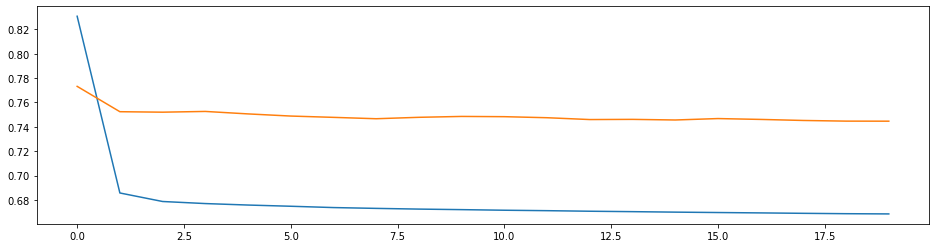

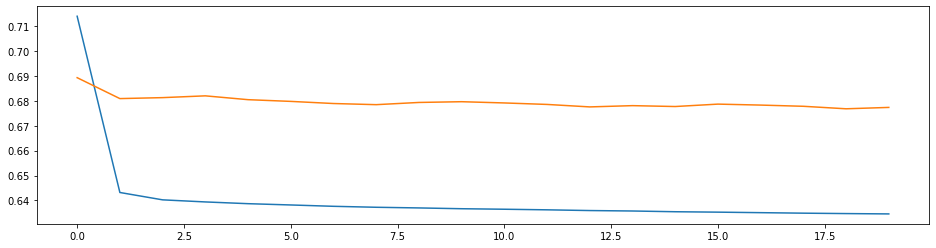

In [31]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
ax.plot(loss_train, label='Train')
ax.plot(loss_valid, label='Validation')
mae_train = history.history['mean_absolute_error']
mae_valid = history.history['val_mean_absolute_error']
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
ax.plot(mae_train, label='Train')
ax.plot(mae_valid, label='Validation')

In [32]:
# Evaluation
test_xp = test_x.reshape(len(test_x),nlat*nlon,3)
test_xp = np.transpose(test_xp, (0, 2, 1))
pred = model.predict(test_xp)
print(np.shape(test_predictands),np.shape(pred))
mse = mean_squared_error(pred, test_predictands)
print('MSE:', mse)

(311480,) (311480, 1)
MSE: 0.65975374


(1198, 13, 20) (1198, 13, 20)


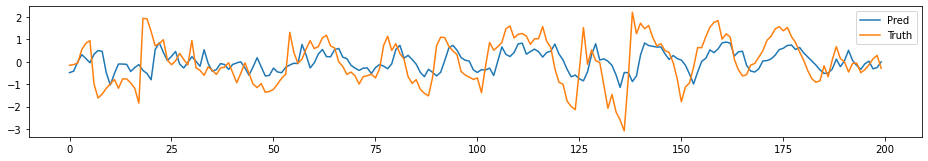

In [34]:
#plot spi time series at random location
pred_3d = pred.reshape(orig_shape_ytest)
test_predictands_3d = test_predictands.reshape(orig_shape_ytest)
print(np.shape(test_predictands_3d),np.shape(pred_3d))
fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
lati = np.random.randint(pred_3d.shape[1])
loni = np.random.randint(pred_3d.shape[2])
plt.plot(pred_3d[100:300,lati,loni], label='Pred')
plt.plot(test_predictands_3d[100:300,lati,loni], label='Truth')
plt.legend()

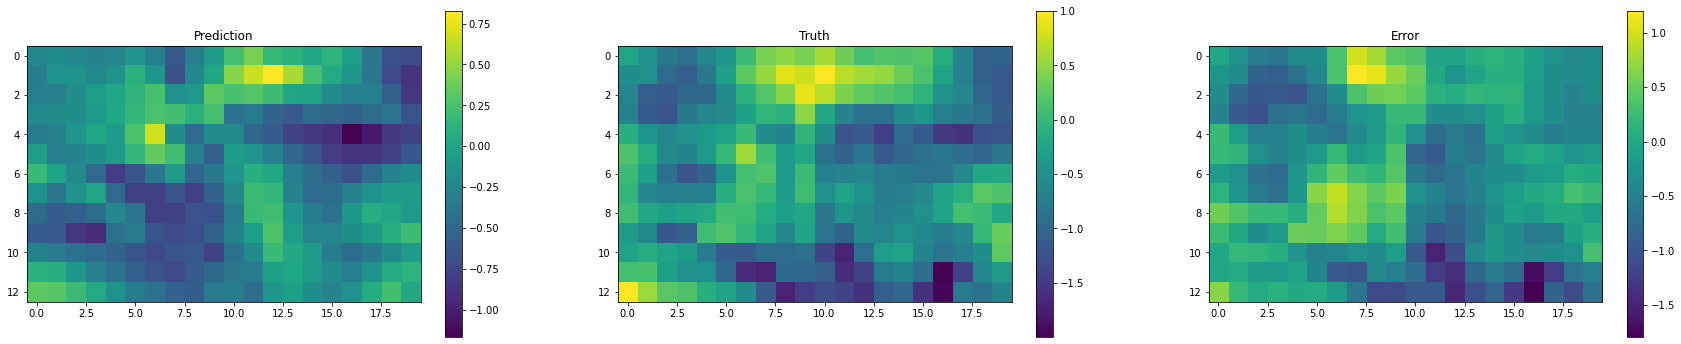

In [37]:
time = np.random.randint(pred_3d.shape[0])
plt.figure(figsize=(30,6))
plt.subplot(1,3,1)
plt.title('Prediction')
plt.imshow(pred_3d[time,:,:])
plt.colorbar()
plt.subplot(1,3,2)
plt.title('Truth')
plt.imshow(test_predictands_3d[time,:,:])
plt.colorbar()
plt.subplot(1,3,3)
plt.title('Error')
plt.imshow(test_predictands_3d[time,:,:]-pred_3d[time,:,:])
plt.colorbar()

In [ ]:
for ii in range(1):
    jj = randint(0,len(train_xt)-1500)  # randomly select 1500 successive months to train because it takes too long to train all the samples
    train_xp = train_x[jj:jj+1500,:,:,:,:,:]
    train_xp = train_xp.reshape(len(train_xp)*nlat*nlon,nlat*nlon,3)
    train_xp = np.transpose(train_xp, (0, 2, 1))
    train_yp = train_yt[jj:jj+1500,:,:]
    train_yp = train_yp.reshape(len(train_yp)*nlat*nlon,1)
    valid_xp = valid_x.reshape(len(valid_x),nlat*nlon,3)
    valid_xp = np.transpose(valid_xp, (0, 2, 1))
    
    input_tensor = Input(shape=(3,nlon*nlat))
    layer1 = layers. Conv1D(filters=64, kernel_size=2, activation='relu')(input_tensor)
    layer1 = layers.MaxPooling1D(pool_size=2)(layer1)
    layer1 = layers.Flatten()(layer1)
    layer1 = layers.Dense(100, activation='relu')(layer1)
    #layer1 = layers.Conv1D(2,3,activation="relu")(layer1)
    #layer1 = layers.MaxPooling1D(1)(layer1)
    #layer1 = layers.Conv1D(2,1,activation="relu")(layer1)
    #layer1 = layers.GlobalAveragePooling1D()(layer1)
    output_tensor = layers.Dense(1)(layer1)
    path_save_weigths = '/net/cfc/s2s/zhengwu/code/tmp/hackathon_cnn.h5'
    callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=path_save_weigths,
            monitor='val_loss',
            save_best_only=True,
        )
    ]
    model = Model(input_tensor, output_tensor)
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    history = model.fit(train_xp, train_yp, epochs=20, batch_size=256, callbacks=callbacks_list, validation_data=(valid_xp, valid_predictands), verbose=2)
    loss_train = history.history['loss']
    loss_valid = history.history['val_loss']

Train on 390000 samples, validate on 155480 samples
Epoch 1/20
 - 8s - loss: 0.7354 - mean_absolute_error: 0.6715 - val_loss: 0.7882 - val_mean_absolute_error: 0.6973
Epoch 2/20
 - 6s - loss: 0.6961 - mean_absolute_error: 0.6520 - val_loss: 0.7823 - val_mean_absolute_error: 0.6955
Epoch 3/20
 - 6s - loss: 0.6905 - mean_absolute_error: 0.6489 - val_loss: 0.7738 - val_mean_absolute_error: 0.6917
Epoch 4/20
 - 6s - loss: 0.6859 - mean_absolute_error: 0.6464 - val_loss: 0.7704 - val_mean_absolute_error: 0.6886
Epoch 5/20
 - 6s - loss: 0.6817 - mean_absolute_error: 0.6441 - val_loss: 0.7686 - val_mean_absolute_error: 0.6873
Epoch 6/20
 - 6s - loss: 0.6788 - mean_absolute_error: 0.6426 - val_loss: 0.7639 - val_mean_absolute_error: 0.6867
Epoch 7/20
 - 6s - loss: 0.6758 - mean_absolute_error: 0.6408 - val_loss: 0.7646 - val_mean_absolute_error: 0.6861
Epoch 8/20
 - 6s - loss: 0.6738 - mean_absolute_error: 0.6397 - val_loss: 0.7660 - val_mean_absolute_error: 0.6856
Epoch 9/20
 - 6s - loss: 0.6

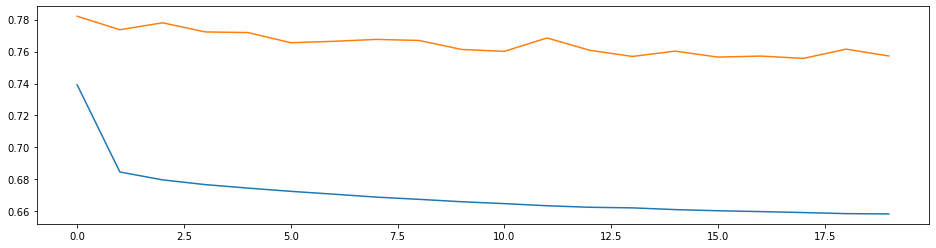

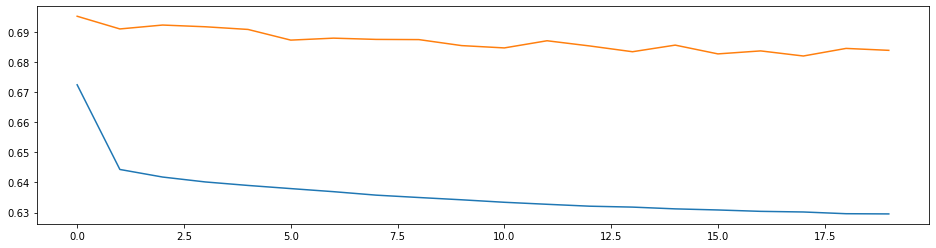

In [51]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
ax.plot(loss_train, label='Train')
ax.plot(loss_valid, label='Validation')
mae_train = history.history['mean_absolute_error']
mae_valid = history.history['val_mean_absolute_error']
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
ax.plot(mae_train, label='Train')
ax.plot(mae_valid, label='Validation')

In [52]:
# Evaluation
test_xp = test_x.reshape(len(test_x),nlat*nlon,3)
test_xp = np.transpose(test_xp, (0, 2, 1))
pred = model.predict(test_xp)
print(np.shape(test_predictands),np.shape(pred))
mse = mean_squared_error(pred, test_predictands)
print('MSE:', mse)

(311480,) (311480, 1)
MSE: 0.6750072
